In [147]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading data

In [148]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\Users\user\Desktop\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [3]:
weather = pd.read_excel(r'C:\Users\user\Desktop\w.xlsx')
weather.rename(columns={'date':'H_YMD'}, inplace=True)
weather['H_YMD'] = pd.to_datetime(weather['H_YMD'])
weather = weather.sort_values(by = 'H_YMD')
weather.drop('spot', axis=1, inplace=True)

weather

,Unnamed: 0,H_YMD,temp,rain,humid
10824,10824,2019-12-31,-3.60,0.00,51.80
10104,10104,2019-12-31,-7.90,0.00,39.30
10224,10224,2019-12-31,-4.70,0.00,55.00
9864,9864,2019-12-31,-2.50,0.00,33.00
9744,9744,2019-12-31,-2.20,0.00,46.10
...,...,...,...,...,...
15560,15560,2022-07-11,3.83,0.00,54.58
15554,15554,2022-07-11,2.79,0.00,44.79
15578,15578,2022-07-11,2.54,0.00,39.38
15575,15575,2022-07-11,2.42,0.00,54.79


In [352]:
# 카피 데이터 생성
copy_data = raw_data.copy()

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')


copy_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
166288,119348,201912302355791,2020-01-01 00:00:00,2019-12-30 21:59:40,단품,단품,14375,옛날잡채(500g),메인요리,1,0,0,1,"경기도 수원시 장안구 경수대로976번길 22 (조원동, 수원 한일타운)",8600,1408.00,7192
37753,37753,201912302355557,2020-01-01 00:00:00,2019-12-30 20:50:07,단품,단품,1901012353,수제계란말이(350g),반찬,2,0,0,2,서울 성북구 동소문로34길 24 삼성아파트,6300,NaN,6300
162585,115645,201912302353567,2020-01-01 00:00:00,2019-12-30 11:02:39,단품,단품,1823,숙주나물(300g),반찬,1,0,0,1,"서울특별시 마포구 삼개로 33 (도화동, 도화3지구우성아파트)",3300,486.00,2814
164041,117101,201912302354611,2020-01-01 00:00:00,2019-12-30 15:19:58,단품,단품,1712010310,두메산나물비빔밥재료,메인요리,1,0,0,1,경기도 용인시 수지구 문인로3번길 22 (풍덕천동),6900,264.00,6636
164040,117100,201912302352965,2020-01-01 00:00:00,2019-12-30 10:08:58,단품,단품,1712010310,두메산나물비빔밥재료,메인요리,1,0,0,1,"경기도 구리시 아차산로487번길 27 (교문동, 아차산어울림아파트)",6900,317.00,6583


In [342]:
print('Train rows: ', copy_data.shape[0])
print('Train columns: ', copy_data.shape[1])

Train rows:  724702
Train columns:  17


In [343]:
copy_data.head().T

,166288,37753,162585,164041,164040
Unnamed: 0,119348,37753,115645,117101,117100
ORD_NO,201912302355791,201912302355557,201912302353567,201912302354611,201912302352965
H_YMD,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
O_YMD,2019-12-30 21:59:40,2019-12-30 20:50:07,2019-12-30 11:02:39,2019-12-30 15:19:58,2019-12-30 10:08:58
PKG_GOODS_NO,단품,단품,단품,단품,단품
PKG_GOODS_NM,단품,단품,단품,단품,단품
GOODS_NO,14375,1901012353,1823,1712010310,1712010310
GOODS_NM,옛날잡채(500g),수제계란말이(350g),숙주나물(300g),두메산나물비빔밥재료,두메산나물비빔밥재료
STD_GSGR_NO_LEV1_NM,메인요리,반찬,반찬,메인요리,메인요리
ORD_QTY,1,2,1,1,1


In [344]:
copy_data.describe()

,Unnamed: 0,ORD_NO,GOODS_NO,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
count,724702.00,724702.00,724702.00,724702.00,724702.00,724702.00,724702.00,724702.00,348455.00,724702.00
mean,318450.87,202088333648445.66,1042033183.53,1.12,0.05,0.00,1.07,7262.44,1118.63,6724.57
std,204545.75,70694124033.08,913607986.64,0.47,0.29,0.07,0.50,2417.24,1852.83,2388.22
min,0.00,201912042268712.00,1823.00,1.00,0.00,0.00,0.00,2600.00,0.00,-31390.00
25%,134235.25,202009243619033.25,14375.00,1.00,0.00,0.00,1.00,4900.00,169.00,4783.00
50%,315410.50,202104194554775.00,1712010310.00,1.00,0.00,0.00,1.00,7000.00,480.00,6900.00
75%,496585.75,202111045298879.00,1808011751.00,1.00,0.00,0.00,1.00,8800.00,1250.00,8600.00
max,677761.00,202205306073299.00,2204016772.00,45.00,31.00,7.00,45.00,35600.00,39990.00,35600.00


In [353]:
copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
print('Min H_YMD from train set: %s' % copy_data['H_YMD'].min().date())
print('Max H_YMD from train set: %s' % copy_data['H_YMD'].max().date())

Min H_YMD from train set: 2020-01-01
Max H_YMD from train set: 2022-05-31


### Feature Engineering

### Data cleaning

In [354]:
def outlier(df,col):
    q1 = df[col].quantile(0.25) # 1사분위
    q3 = df[col].quantile(0.75) # 3사분위 
    iqr = q3 - q1               # iqr 수치

    df.loc[(df[col] > (q3 + 1.5 * iqr)) | (df[col] < (q1 - 1.5 * iqr)), col] = df[col].median() # 이상치를 중앙값으로 대체

ol_col = ['ORD_QTY', 'REAL_ORD_QTY', 'SALE_PRICE']

for i in ol_col:
    outlier(copy_data, i)

### Data processing

In [156]:
copy_data.columns

Index(['Unnamed: 0', 'ORD_NO', 'H_YMD', 'O_YMD', 'PKG_GOODS_NO',
       'PKG_GOODS_NM', 'GOODS_NO', 'GOODS_NM', 'STD_GSGR_NO_LEV1_NM',
       'ORD_QTY', 'CANCEL_QTY', 'RET_QTY', 'REAL_ORD_QTY',
       'RECVR_ROAD_BASE_ADDR', 'SALE_PRICE', 'DISCOUNT_AMT', 'FINAL_PRICE'],
      dtype='object')

In [355]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제

# dummy_col = ['Unnamed: 0', 'O_YMD', 'ORD_NO', 'PKG_GOODS_NO', 'RECVR_ROAD_BASE_ADDR']
dummy_col = ['Unnamed: 0', 'ORD_NO', 'O_YMD', 'PKG_GOODS_NO',
       'PKG_GOODS_NM', 'STD_GSGR_NO_LEV1_NM', 'GOODS_NM', 'CANCEL_QTY', 'RET_QTY',
       'RECVR_ROAD_BASE_ADDR', 'DISCOUNT_AMT', 'FINAL_PRICE']
copy_data = copy_data.drop(dummy_col, axis=1)

copy_data.head()

,H_YMD,GOODS_NO,ORD_QTY,REAL_ORD_QTY,SALE_PRICE
166288,2020-01-01,14375,1,1,8600
37753,2020-01-01,1901012353,1,1,6300
162585,2020-01-01,1823,1,1,3300
164041,2020-01-01,1712010310,1,1,6900
164040,2020-01-01,1712010310,1,1,6900


In [274]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724702 entries, 166288 to 237568
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   H_YMD         724702 non-null  object
 1   GOODS_NO      724702 non-null  int64 
 2   ORD_QTY       724702 non-null  int64 
 3   REAL_ORD_QTY  724702 non-null  int64 
 4   SALE_PRICE    724702 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 33.2+ MB


In [356]:
# Extract time based features.
copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
copy_data['year'] = pd.to_datetime(copy_data['H_YMD']).dt.year
copy_data['month'] = pd.to_datetime(copy_data['H_YMD']).dt.month
copy_data['day'] = pd.to_datetime(copy_data['H_YMD']).dt.day

In [237]:
copy_data.head()

,H_YMD,GOODS_NO,ORD_QTY,REAL_ORD_QTY,SALE_PRICE,year,month,day
166288,2020-01-01,14375,1,1,8600,2020,1,1
37753,2020-01-01,1901012353,1,1,6300,2020,1,1
162585,2020-01-01,1823,1,1,3300,2020,1,1
164041,2020-01-01,1712010310,1,1,6900,2020,1,1
164040,2020-01-01,1712010310,1,1,6900,2020,1,1


In [357]:
copy_data['date_block_num'] = 0
copy_data['date_block_num'].loc[copy_data['year']==2020] = (copy_data['month'] - 1)
copy_data['date_block_num'].loc[copy_data['year']==2021] = (copy_data['month'] + 11)
copy_data['date_block_num'].loc[copy_data['year']==2022] = (copy_data['month'] + 23)

copy_data['date_block_num'][200000:200100]

275506    9
270727    9
265351    9
271846    9
265346    9
         ..
265408    9
265049    9
280233    9
269041    9
272195    9
Name: date_block_num, Length: 100, dtype: int64

In [358]:
# Group by month in this case "date_block_num" and aggregate features.
copy_data = copy_data.groupby(['H_YMD', 'GOODS_NO'], as_index=False)
copy_data = copy_data.agg({
                           'SALE_PRICE':['sum', 'mean'], 
                           'ORD_QTY':['sum', 'mean', 'count'], 
                           'REAL_ORD_QTY':['sum', 'mean','count'], 
                        })
# Rename features.
copy_data.columns = [
                     'H_YMD', 'GOODS_NO',
                     'SALE_PRICE', 'mean_sale_price',
                     'ORD_QTY', 'mean_ord_qty',  'ord_transactions', 
                     'REAL_ORD_QTY', 'mean_real_ord_qty', 'real_transactions',
                     ]
                     
copy_data

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,mean_real_ord_qty,real_transactions
0,2020-01-01,1823,82500,3300.00,25,1.00,25,25,1.00,25
1,2020-01-01,3273,92400,4200.00,22,1.00,22,22,1.00,22
2,2020-01-01,4092,36000,4000.00,9,1.00,9,9,1.00,9
3,2020-01-01,13957,88200,4900.00,18,1.00,18,18,1.00,18
4,2020-01-01,14375,722400,8600.00,84,1.00,84,84,1.00,84
...,...,...,...,...,...,...,...,...,...,...
10925,2022-05-31,2010014667,143000,6500.00,22,1.00,22,22,1.00,22
10926,2022-05-31,2010014707,297600,9600.00,31,1.00,31,31,1.00,31
10927,2022-05-31,2012014895,715500,13500.00,53,1.00,53,53,1.00,53
10928,2022-05-31,2103015231,386100,9900.00,39,1.00,39,39,1.00,39


In [295]:
copy_data.head()

,H_YMD,GOODS_NO,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,mean_real_ord_qty,real_transactions,SALE_PRICE,mean_sale_price,year,month,day
0,2020-01-01,1823,82500,3300.00,25,1.00,25,25,1.00,25,2020,1,1
1,2020-01-01,3273,92400,4200.00,22,1.00,22,22,1.00,22,2020,1,1
2,2020-01-01,4092,36000,4000.00,9,1.00,9,9,1.00,9,2020,1,1
3,2020-01-01,13957,88200,4900.00,18,1.00,18,18,1.00,18,2020,1,1
4,2020-01-01,14375,722400,8600.00,84,1.00,84,84,1.00,84,2020,1,1


In [351]:
# copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
# train_data = copy_data.loc[~((copy_data['H_YMD'].dt.year == 2022) & (copy_data['H_YMD'].dt.month == 5))]
# test_data = copy_data.loc[(copy_data['H_YMD'].dt.year == 2022) & (copy_data['H_YMD'].dt.month == 5)]



In [302]:
train_data.head()

,H_YMD,GOODS_NO,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,mean_real_ord_qty,real_transactions,SALE_PRICE,mean_sale_price,year,month,day
0,2020-01-01,1823,82500,3300.00,25,1.00,25,25,1.00,25,2020,1,1
1,2020-01-01,3273,92400,4200.00,22,1.00,22,22,1.00,22,2020,1,1
2,2020-01-01,4092,36000,4000.00,9,1.00,9,9,1.00,9,2020,1,1
3,2020-01-01,13957,88200,4900.00,18,1.00,18,18,1.00,18,2020,1,1
4,2020-01-01,14375,722400,8600.00,84,1.00,84,84,1.00,84,2020,1,1


In [359]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
GOODS_NO = copy_data['GOODS_NO'].unique()
empty_df = []
for i in range(28):
    for shop in GOODS_NO:
            empty_df.append([i, shop])
    
empty_df = pd.DataFrame(empty_df, columns=['DATE_BLOCK_NUM','GOODS_NO'])


In [304]:
empty_df

,DATE_BLOCK_NUM,GOODS_NO
0,0,1823
1,0,3273
2,0,4092
3,0,13957
4,0,14375
...,...,...
555,27,2012014895
556,27,2010014667
557,27,2010014707
558,27,2103015231


In [360]:
copy_data.head().T


,0,1,2,3,4
H_YMD,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
GOODS_NO,1823,3273,4092,13957,14375
SALE_PRICE,82500,92400,36000,88200,722400
mean_sale_price,3300.00,4200.00,4000.00,4900.00,8600.00
ORD_QTY,25,22,9,18,84
mean_ord_qty,1.00,1.00,1.00,1.00,1.00
ord_transactions,25,22,9,18,84
REAL_ORD_QTY,25,22,9,18,84
mean_real_ord_qty,1.00,1.00,1.00,1.00,1.00
real_transactions,25,22,9,18,84


In [361]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, copy_data, on=['GOODS_NO'], how='left')
train_monthly.fillna(0, inplace=True)

In [362]:
train_monthly.head().T

,0,1,2,3,4
DATE_BLOCK_NUM,0,0,0,0,0
GOODS_NO,1823,1823,1823,1823,1823
H_YMD,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-06 00:00:00
SALE_PRICE,82500,108700,134700,108500,125400
mean_sale_price,3300.00,3293.94,3285.37,3287.88,3300.00
ORD_QTY,25,33,41,33,38
mean_ord_qty,1.00,1.00,1.00,1.00,1.00
ord_transactions,25,33,41,33,38
REAL_ORD_QTY,25,33,41,33,38
mean_real_ord_qty,1.00,1.00,1.00,1.00,1.00


In [363]:
# Extract time based features.
train_monthly['year'] = train_monthly['H_YMD'].dt.year
train_monthly['month'] = train_monthly['H_YMD'].dt.month
train_monthly['day'] = train_monthly['H_YMD'].dt.day

In [364]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['REAL_ORD_QTY'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['REAL_ORD_QTY'].sum()
gp_category_mean = train_monthly.groupby(['GOODS_NO'], as_index=False)['REAL_ORD_QTY'].mean()
gp_category_sum = train_monthly.groupby(['GOODS_NO'], as_index=False)['REAL_ORD_QTY'].sum()

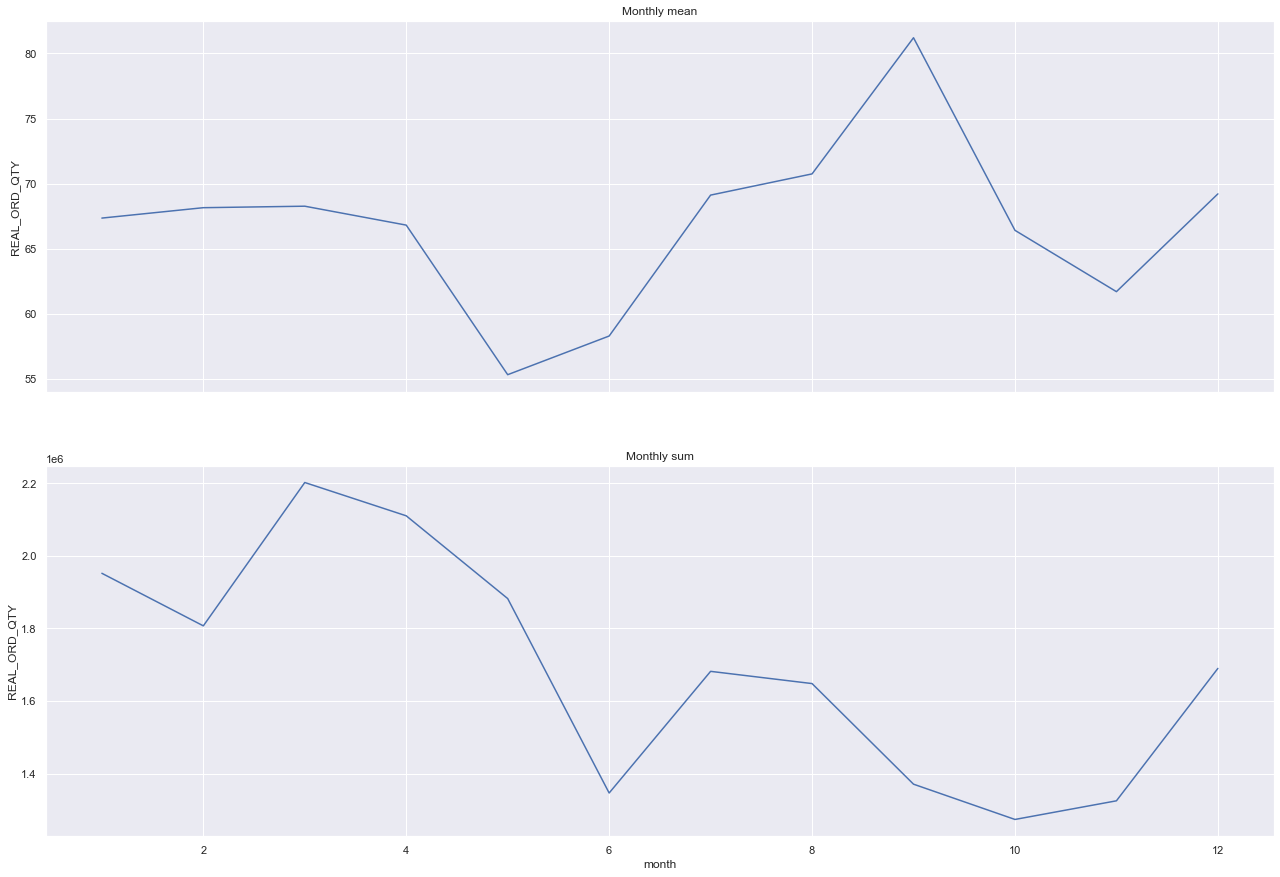

In [365]:
f, axes = plt.subplots(2, 1, figsize=(22, 15), sharex=True)
sns.lineplot(x="month", y="REAL_ORD_QTY", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="REAL_ORD_QTY", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

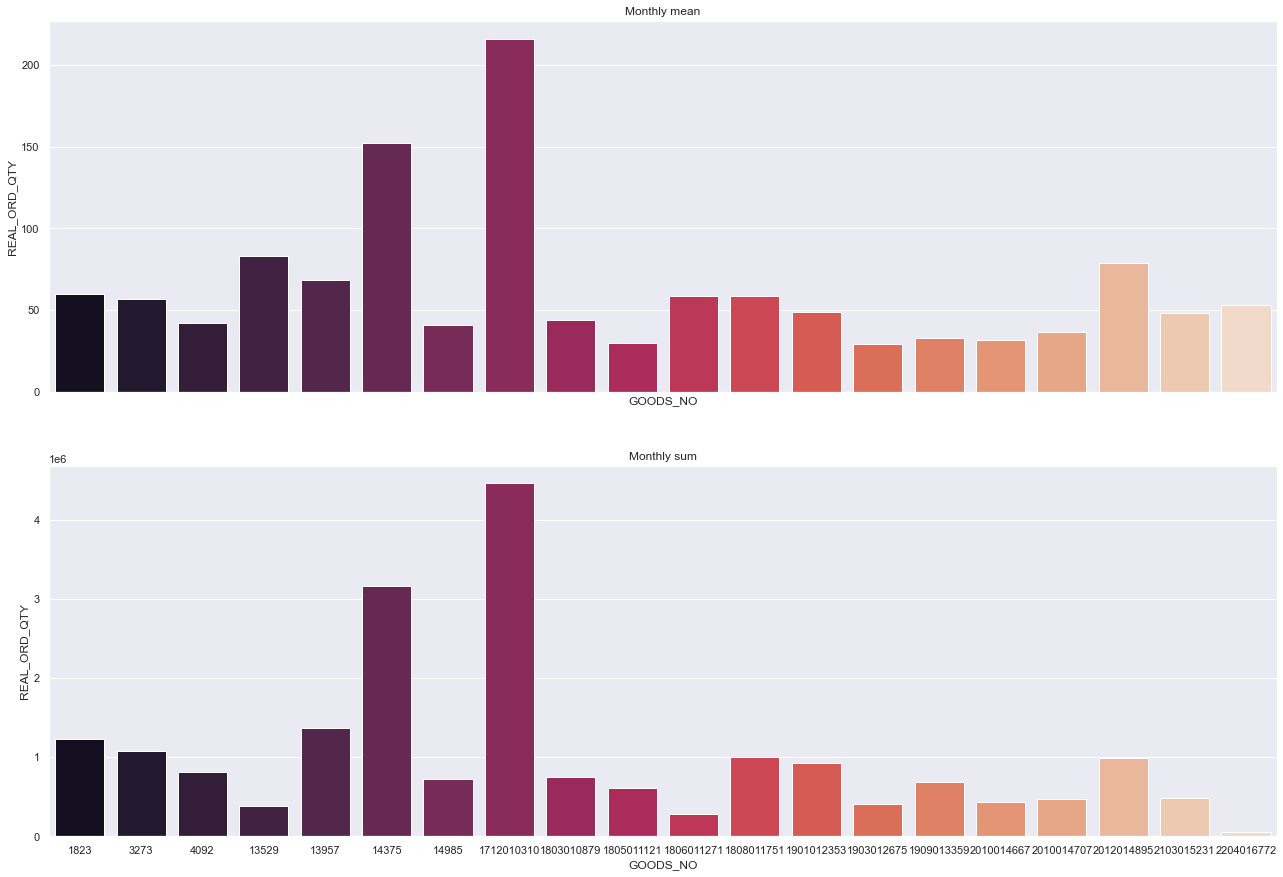

In [366]:
f, axes = plt.subplots(2, 1, figsize=(22, 15), sharex=True)
sns.barplot(x="GOODS_NO", y="REAL_ORD_QTY", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="GOODS_NO", y="REAL_ORD_QTY", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

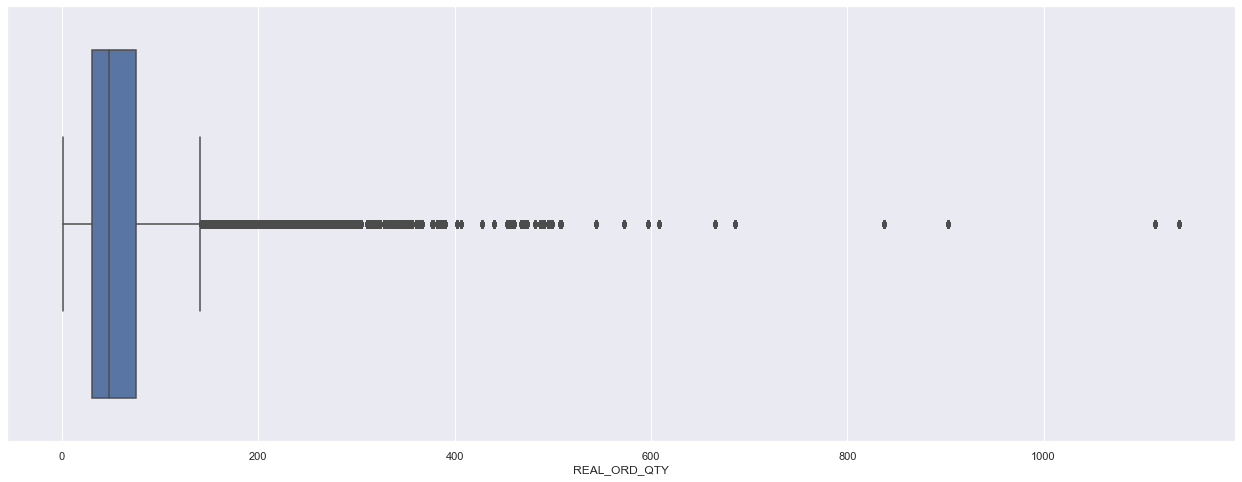

In [324]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['REAL_ORD_QTY'])
plt.show()

In [367]:
train_monthly['item_cnt_day'] = train_monthly.sort_values('DATE_BLOCK_NUM').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(-1)

In [368]:
train_monthly['item_price_unit'] = train_monthly['SALE_PRICE'] // train_monthly['REAL_ORD_QTY']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [369]:
gp_item_price = train_monthly.sort_values('DATE_BLOCK_NUM').groupby(['GOODS_NO'], as_index=False).agg({'SALE_PRICE':[np.min, np.max]})
gp_item_price.columns = ['GOODS_NO', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='GOODS_NO', how='left')

In [370]:
train_monthly['price_increase'] = train_monthly['SALE_PRICE'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['SALE_PRICE']

In [330]:
type( train_monthly.sort_values('DATE_BLOCK_NUM').groupby(['GOODS_NO'])['REAL_ORD_QTY'])

pandas.core.groupby.generic.SeriesGroupBy

In [73]:
type( train_monthly['REAL_ORD_QTY'])

pandas.core.series.Series

In [371]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('REAL_ORD_QTY_%s' % function_name[i])] = train_monthly.sort_values('DATE_BLOCK_NUM').groupby(['GOODS_NO'])['REAL_ORD_QTY'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['REAL_ORD_QTY_std'].fillna(0, inplace=True)

In [338]:
train_monthly

,DATE_BLOCK_NUM,GOODS_NO,H_YMD,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,mean_real_ord_qty,...,REAL_ORD_QTY_min,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std,REAL_ORD_QTY_shifted1,REAL_ORD_QTY_shifted2,REAL_ORD_QTY_shifted3,item_trend,price_increase,price_decrease
0,0,1823,2020-01-01,82500,3300.00,25,1.00,25,25,1.00,...,25.00,25.00,25.00,0.00,0.00,0.00,0.00,6.25,33000,438900
1,0,1823,2020-01-02,108700,3293.94,33,1.00,33,33,1.00,...,33.00,63.00,52.00,16.52,60.00,63.00,50.00,-35.00,59200,412700
2,0,1823,2020-01-03,134700,3285.37,41,1.00,41,41,1.00,...,23.00,58.00,40.67,17.50,58.00,23.00,69.00,-27.25,85200,386700
3,0,1823,2020-01-04,108500,3287.88,33,1.00,33,33,1.00,...,33.00,58.00,44.00,12.77,41.00,58.00,23.00,-22.25,59000,412900
4,0,1823,2020-01-06,125400,3300.00,38,1.00,38,38,1.00,...,33.00,41.00,37.33,4.04,33.00,41.00,58.00,-23.50,75900,396000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292259,27,2204016772,2022-04-26,239400,3800.00,63,1.00,63,63,1.00,...,63.00,82.00,72.33,9.50,82.00,72.00,98.00,-47.25,83600,133000
292260,27,2204016772,2022-04-27,273600,3800.00,72,1.00,72,72,1.00,...,63.00,82.00,72.33,9.50,63.00,82.00,72.00,-36.25,117800,98800
292261,27,2204016772,2022-04-28,273600,3800.00,72,1.00,72,72,1.00,...,41.00,72.00,55.67,15.57,41.00,54.00,72.00,-23.75,117800,98800
292262,27,2204016772,2022-04-29,205200,3800.00,54,1.00,54,54,1.00,...,54.00,72.00,64.00,9.17,66.00,72.00,63.00,-36.75,49400,167200


In [372]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('REAL_ORD_QTY_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('DATE_BLOCK_NUM').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [373]:
train_monthly['item_trend'] = train_monthly['REAL_ORD_QTY']

for lag in lag_list:
    ft_name = ('REAL_ORD_QTY_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [335]:
train_monthly.head().T

,0,1,2,3,4
DATE_BLOCK_NUM,0,0,0,0,0
GOODS_NO,1823,1823,1823,1823,1823
H_YMD,2020-01-01 00:00:00,2020-01-02 00:00:00,2020-01-03 00:00:00,2020-01-04 00:00:00,2020-01-06 00:00:00
SALE_PRICE,82500,108700,134700,108500,125400
mean_sale_price,3300.00,3293.94,3285.37,3287.88,3300.00
ORD_QTY,25,33,41,33,38
mean_ord_qty,1.00,1.00,1.00,1.00,1.00
ord_transactions,25,33,41,33,38
REAL_ORD_QTY,25,33,41,33,38
mean_real_ord_qty,1.00,1.00,1.00,1.00,1.00


In [375]:
train_monthly

,DATE_BLOCK_NUM,GOODS_NO,H_YMD,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,mean_real_ord_qty,...,price_increase,price_decrease,REAL_ORD_QTY_min,REAL_ORD_QTY_max,REAL_ORD_QTY_mean,REAL_ORD_QTY_std,REAL_ORD_QTY_shifted1,REAL_ORD_QTY_shifted2,REAL_ORD_QTY_shifted3,item_trend
0,0,1823,2020-01-01,82500,3300.00,25,1.00,25,25,1.00,...,33000,1089000,25.00,25.00,25.00,0.00,0.00,0.00,0.00,6.25
1,0,1823,2020-01-02,108700,3293.94,33,1.00,33,33,1.00,...,59200,1062800,33.00,67.00,53.33,17.95,60.00,67.00,29.00,-30.75
2,0,1823,2020-01-03,134700,3285.37,41,1.00,41,41,1.00,...,85200,1036800,23.00,69.00,44.33,23.18,23.00,69.00,80.00,-32.75
3,0,1823,2020-01-04,108500,3287.88,33,1.00,33,33,1.00,...,59000,1063000,23.00,41.00,32.33,9.02,41.00,23.00,69.00,-25.00
4,0,1823,2020-01-06,125400,3300.00,38,1.00,38,38,1.00,...,75900,1046100,33.00,41.00,37.33,4.04,33.00,41.00,23.00,-14.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306035,27,2204016772,2022-05-26,79800,3800.00,21,1.00,21,21,1.00,...,0,292600,21.00,53.00,41.33,17.67,50.00,53.00,75.00,-39.25
306036,27,2204016772,2022-05-27,148200,3800.00,39,1.00,39,39,1.00,...,68400,224200,21.00,50.00,36.67,14.64,21.00,50.00,53.00,-21.25
306037,27,2204016772,2022-05-28,102600,3800.00,27,1.00,27,27,1.00,...,22800,269800,21.00,63.00,37.00,22.72,63.00,21.00,76.00,-33.25
306038,27,2204016772,2022-05-30,159600,3800.00,42,1.00,42,42,1.00,...,79800,212800,42.00,82.00,66.67,21.57,82.00,76.00,40.00,-39.00


In [377]:
train_set = train_monthly.query('DATE_BLOCK_NUM >= 0 and DATE_BLOCK_NUM < 20').copy()
validation_set = train_monthly.query('DATE_BLOCK_NUM >= 20 and DATE_BLOCK_NUM < 27').copy()
test_set = train_monthly.query('DATE_BLOCK_NUM == 27').copy()

train_set.dropna(subset=['item_cnt_day'], inplace=True)
validation_set.dropna(subset=['item_cnt_day'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 218600
Validation set records: 76510
Test set records: 10930
Train set records: 218600 (71% of complete data)
Validation set records: 76510 (25% of complete data)


In [378]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_shop_mean.columns = ['GOODS_mean']
gp_shop_mean.reset_index(inplace=True)

# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['GOODS_NO'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['GOODS_NO'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [379]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_day', 'DATE_BLOCK_NUM'], axis=1)
Y_train = train_set['item_cnt_day'].astype(int)
X_validation = validation_set.drop(['item_cnt_day', 'DATE_BLOCK_NUM'], axis=1)
Y_validation = validation_set['item_cnt_day'].astype(int)

In [380]:
# Integer features (used by catboost model).
int_features = ['GOODS_NO', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [385]:
test_set.columns

Index(['DATE_BLOCK_NUM', 'GOODS_NO', 'H_YMD', 'SALE_PRICE', 'mean_sale_price',
       'ORD_QTY', 'mean_ord_qty', 'ord_transactions', 'REAL_ORD_QTY',
       'mean_real_ord_qty', 'real_transactions', 'year', 'month', 'day',
       'item_price_unit', 'hist_min_item_price', 'hist_max_item_price',
       'price_increase', 'price_decrease', 'REAL_ORD_QTY_min',
       'REAL_ORD_QTY_max', 'REAL_ORD_QTY_mean', 'REAL_ORD_QTY_std',
       'REAL_ORD_QTY_shifted1', 'REAL_ORD_QTY_shifted2',
       'REAL_ORD_QTY_shifted3', 'item_trend'],
      dtype='object')

In [383]:
# latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['GOODS_NO'], keep='last')
# X_test = test_set
# X_test.drop('item_cnt_day', axis=1, inplace=True)
# X_test[int_features] = X_test[int_features].astype('int32')
# #X_test = X_test[X_train.columns]

# X_test

KeyError: "['item_cnt_day'] not found in axis"